# Sequence Analysis and Functional Prediction Pipeline

## 1. Introduction
This notebook analyzes the functional and sequence relationships between newly identified bacteria and known corrosion-influencing microorganisms. The analysis builds upon previous findings where:
- Statistical significance was established between the selected bacteria and corrosion risk (Notebook 3)
- Literature validation confirmed corrosion influence for many bacteria (Notebook 4)
- Evolutionary relationships were mapped through phylogenetic analysis (Notebook 5)

The study focuses on bacteria from operational heating and cooling water systems, primarily in Germany. Using 16S rRNA data (bootstrap-validated from Notebook 5), this analysis employs PICRUSt2 to predict metabolic functions and compare functional profiles between different bacterial groups.

### Analysis Approaches
We implement two classification strategies:

1. Simple Classification:
   - Known corrosion-causing bacteria (usual_taxa)
   - Other bacteria (combining checked_taxa and core_taxa)

2. Detailed Classification:
   - Known corrosion-causing bacteria (usual_taxa)
   - Pure checked bacteria (exclusive to checked_taxa)
   - Pure core bacteria (exclusive to core_taxa)
   - Checked-core bacteria (overlap between checked and core taxa)

This detailed approach allows for more nuanced analysis of functional profiles and better understanding of potential corrosion mechanisms across different bacterial groups.

### Analysis Goals:
- Predict metabolic functions from 16S sequences
- Focus on corrosion-relevant pathways (sulfur/iron metabolism)
- Compare functional profiles between known corrosion-causing bacteria and newly identified candidates
- Validate whether statistical correlations reflect genuine metabolic capabilities associated with corrosion processes

### Directory Structure:
 Following is the structure of the notebook data named data_picrus  
data_tree  
 ├── sequences/  
 │   ├── known.fasta : sequences of known corrosion-causing bacteria  
 │   ├── candidate.fasta : sequences of potential new corrosion-causing bacteria  
 |   └── other files  
 data_picrus  
 └── picrust_results/  
      ├── known_bacteria/  
      |               ├── EC_predictions/       : enzyme predictions  
      |               ├── pathway_predictions/  : metabolic pathway abundance  
      |               ├── KO_predictions/       : KEGG ortholog predictions  
      |               └── other_picrust_files/  
      ├── candidate_bacteria/  
      |               ├── EC_predictions/       : enzyme predictions  
      |               ├── pathway_predictions/  : metabolic pathway abundance  
      |               ├── KO_predictions/       : KEGG ortholog predictions  
      |               └── other_picrust_files/  : final comparison summary
      ├── core_bacteria/
      |               ├── EC_predictions/       : enzyme predictions  
      |               ├── pathway_predictions/  : metabolic pathway abundance  
      |               ├── KO_predictions/       : KEGG ortholog predictions  
      |               └── other_picrust_files/  
      │      
      └── functional_comparison.xlsx  

Picrust2 works using its reference database that was installed with the package   
~/miniconda3/envs/picrust2/lib/python3.9/site-packages/picrust2/default_files/prokaryotic/pro_ref

About picrust2  
https://evomics.org/wp-content/uploads/2015/01/presentation_evomics-05-picrust_01-18-15.pdf

# 2. Loading and Preparing the Data

## 2.1 Colab Initialisation

__Importing PICRUST IN COLAB__

In [1]:
'''# Install miniconda and initialize
!wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!bash Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local/miniconda3
!conda config --add channels defaults
!conda config --add channels bioconda
!conda config --add channels conda-forge
# Imports for colab
import condacolab
import sys
sys.path.append('/usr/local/miniconda3/lib/python3.7/site-packages/')

# Install PICRUSt2 and its dependencies
!conda install -c bioconda -c conda-forge picrust2=2.4.1 -y
# Verify installations
!conda list | grep picrust2'''

"# Install miniconda and initialize\n!wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh\n!bash Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local/miniconda3\n!conda config --add channels defaults\n!conda config --add channels bioconda\n!conda config --add channels conda-forge\n# Imports for colab\nimport condacolab\nimport sys\nsys.path.append('/usr/local/miniconda3/lib/python3.7/site-packages/')\n\n# Install PICRUSt2 and its dependencies\n!conda install -c bioconda -c conda-forge picrust2=2.4.1 -y\n# Verify installations\n!conda list | grep picrust2"

__Mounting the Drive__

In [2]:
'''from google.colab import drive
drive.mount('/content/drive')

#change the path
os.chdir('/content/drive/My Drive/MIC/picrust')'''

"from google.colab import drive\ndrive.mount('/content/drive')\n\n#change the path\nos.chdir('/content/drive/My Drive/MIC/picrust')"

# 2.2. Importing Libraries,  Making Directories and Loading Data

In [5]:
# Standard library imports
import os
import ast
import subprocess
import logging
from datetime import datetime
import shutil
from io import StringIO
from pathlib import Path
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

# Data processing imports
import pandas as pd
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap

# BIOM handling
from biom import Table
from biom.util import biom_open
from biom import load_table

In [6]:
# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Directory Structure Definitions
SIMPLE_BASE = {
    'known': 'simple_known_mic',
    'other': 'simple_candidate_mic'
}

DETAILED_BASE = {
    'known': 'detailed_known_mic',
    'pure_checked': 'detailed_pure_checked_mic',
    'pure_core': 'detailed_pure_core_mic',
    'checked_core': 'detailed_checked_core_mic'
}

SUBDIRS = [
    'EC_predictions',
    'pathway_predictions',
    'KO_predictions',
    'other_picrust_files'
]

# Base Paths
base_dir = Path("/home/beatriz/MIC/2_Micro/data_picrust")
# Create output directory if it doesn't exist
base_dir.mkdir(parents=True, exist_ok=True)
abundance_excel= Path("/home/beatriz/MIC/2_Micro/data_Ref/merged_to_sequence.xlsx")
fasta_file = Path("/home/beatriz/MIC/2_Micro/data_qiime/results_match_gg/final_sequences_gg.fasta")
aligned_fasta = Path("/home/beatriz/MIC/2_Micro/data_qiime/results_match_gg/aligned-dna-sequences_gg.fasta")
results_file = base_dir / "functional_comparison.xlsx"
output_dir = base_dir / "picrust2_out"  # Separate output directory

The fasta file come from the Alternative Sequences finding from the Greenes Genes Database, from the taxonomy in this study made in section 7 in the 5_Sequences_qiime notebook: final_sequences_gg.fasta. Abundance dataframe come from the data from notebook 4 merged_to_sequence.xlsx sheet=core_check_usual_taxa which is a unified df between 3 different groups explained previously: cora_taxa (>20% 60 abundance features), usual_taxa (17 high literature ranking bacteria influencing corrosion) and checked_taxa (30 statistically significant to the corrosion risk label) in total 85 features. 

In [5]:
# Integrated taxa from origin genus as headers with levels 6 for the genera, 7 for the GID, muss be cleaned
Integrated_T = pd.read_excel(abundance_excel, sheet_name='core_check_usual_taxa', header=[0,1,2,3,4,5,6,7], engine ='openpyxl')
# Drop first row (index 0) and first column in one chain
Integrated_T = Integrated_T.drop(index=0).drop(Integrated_T.columns[0], axis=1)
# Remove 'Unnamed' level names
Integrated_T.columns = Integrated_T.columns.map(lambda x: tuple('' if 'Unnamed' in str(level) else level for level in x))
# If the dataframe has Nan in sites it will replace it with Source
Integrated_T['Sites'] = Integrated_T['Sites'].fillna('Source')
# Fill the other index with nothing
Integrated_T =  Integrated_T.fillna(' ')
Integrated_T= Integrated_T.set_index("Sites")
pre_Integrated = Integrated_T.T
# sources are  array([' ', 'chk-core', 'chk', 'chk-core-us', 'chk-us', 'core-us', 'core', 'us'], dtype=object)

## 2.3. Making Sequences for Picrust fasta file

Picrust Functional Analyiss requires a biom table with otus as index, samples as headers and abundance as values. The present biom has genus names but is needs instead Otus instead. The other input file for picrust is the representative sequences table that consist of the sequences per genera followed by the frequency of that genera on the whole sample, this is done directly by the software. The fasta file requires the otus instead of the genera names and the sequences non aligned coming from notebook 5. The following scrips will formate the data to picrust.

In [6]:
# Read and modify sequences
new_records = []
for record in SeqIO.parse(fasta_file, "fasta"):
    # Get just the OTU number and ignore genus name
    otu_id = record.description.split()[1]  # Takes second element (the OTU number)
    
    # Create new record with only OTU as ID
    new_record = SeqRecord(
        record.seq,
        id=otu_id,
        description=""  # Empty description to keep only ID
    )
    new_records.append(new_record)

# Write modified FASTA
sequences_for_picrust = Path("/home/beatriz/MIC/2_Micro/data_picrust/sequences_for_picrust.fasta")
SeqIO.write(new_records, sequences_for_picrust, "fasta")

85

## 2.4. Making of Dataframes for 2 Different Pipelines
The following script is the path to the biom file but also to the Integrate dataframe which create dataframes that discriminate its origin in order to pass then through picrust different pipelines, to know: Simple_Base that compares the known bacteria namely usual_taxa against the other features to understand their relationships on the function of their metabolism, an additional group is put forward as simply_candidate_mic which corresponds to the bacteria no previously linked to corrosion but showing an statistical significance with the risk label, those come from the checked_taxa and in this study are: genera(GID): Bulleida (154); Mycoplana (471), Oxobacter (512) and Oerskovia (). Also as showing an favor behaviour against corrosion are presented: Phenylobacterium (549), Gelria(334), Porphyrobacteria (564) and Tepidimonas (712)
SIMPLE_BASE = {'known': 'simple_known_mic', 'other': 'simple_candidate_mic'}
The second pipeline comprises a more detailed separation of the bacteria and that is: The Known bacteria as previously, pure_checked corresponding to the statistical significant genera, pure_core correspondent to the core taxa on the systems and the combination of the core and checked taxa. 
DETAILED_BASE = {'known': 'detailed_known_mic','pure_checked': 'detailed_pure_checked_mic',
    'pure_core': 'detailed_pure_core_mic', 'checked_core': 'detailed_checked_core_mic'}

__Making the Integrated dataframe__
The original dataframe has a column for source, indicating from which df  came from (core, usual, checked), this script proceses that datadrame into individual dfs and the combined preserving the source for further analysis. The Integrated dataframe continues to be process on the next step to become the biom abundance df.

In [7]:
def process_integrated_data(df):
    """
    Process the integrated DataFrame to create a new DataFrame with clear column names
    and preserve all values including source information.

    Parameters:
    df (pandas.DataFrame): Input DataFrame with MultiIndex index and site columns

    Returns:
    pandas.DataFrame: Processed DataFrame with clear structure
    """

    # Extract genera and GIDs from the index MultiIndex
    genera = df.index.get_level_values(6)[1:]  # Skip first row
    gids = pd.to_numeric(df.index.get_level_values(7)[1:], errors='coerce')

    # Create a new DataFrame with the extracted information
    result_df = pd.DataFrame({
        'Genus': genera,
        'GID': gids
    })

    # Add the site values from the original DataFrame
    for col in df.columns:
        result_df[col] = df.iloc[1:][col].values

    # Clean up the DataFrame
    result_df['GID'] = pd.to_numeric(result_df['GID'], errors='coerce')
    result_df = result_df.dropna(subset=['GID'])
    result_df['GID'] = result_df['GID'].astype(int)

    return result_df

def get_taxa_groups(df):
    """
    Separate the processed DataFrame into different taxa groups based on Source column

    Parameters:
    df (pandas.DataFrame): Processed DataFrame from process_integrated_data()

    Returns:
    dict: Dictionary containing DataFrames for different taxa groups
    """
    # Split the data into groups based on 'Source' column patterns

    # Known corrosion bacteria (any pattern with 'us')
    known_bacteria = df[df['Source'].str.contains('us', case=False, na=False)]

    # Pure checked bacteria (only 'chk' without 'core' or 'us')
    pure_checked = df[
        df['Source'].str.contains('chk', case=False, na=False) &
        ~df['Source'].str.contains('core|us', case=False, na=False)
    ]

    # Pure core bacteria (only 'core' without 'chk' or 'us')
    pure_core = df[
        df['Source'].str.contains('core', case=False, na=False) &
        ~df['Source'].str.contains('chk|us', case=False, na=False)
    ]

    # Checked-core bacteria (contains both 'core' and 'chk' but no 'us')
    checked_core = df[
        df['Source'].str.contains('chk.*core|core.*chk', case=False, na=False) &
        ~df['Source'].str.contains('us', case=False, na=False)
    ]

    # Create groups dictionary
    taxa_groups = {
        'known_bacteria': known_bacteria,
        'pure_checked': pure_checked,
        'pure_core': pure_core,
        'checked_core': checked_core
    }

    # Print summary statistics
    print("\nDetailed Classification Results:")
    print(f"Known corrosion bacteria: {len(known_bacteria)}")
    print(f"Pure checked bacteria: {len(pure_checked)}")
    print(f"Pure core bacteria: {len(pure_core)}")
    print(f"Checked-core bacteria: {len(checked_core)}")

    # Verify total matches expected
    total_classified = len(known_bacteria) + len(pure_checked) + len(pure_core) + len(checked_core)
    print(f"\nTotal classified taxa: {total_classified}")
    print(f"Total in dataset: {len(df)}")

    return taxa_groups

# Usage example:
Integrated = process_integrated_data(pre_Integrated)

# Get the groups
taxa_groups = get_taxa_groups(Integrated)

# Access individual groups -
known_bacteria = taxa_groups['known_bacteria']
pure_core = taxa_groups['pure_core']
pure_checked = taxa_groups['pure_checked']
checked_core = taxa_groups['checked_core']


Detailed Classification Results:
Known corrosion bacteria: 17
Pure checked bacteria: 19
Pure core bacteria: 46
Checked-core bacteria: 3

Total classified taxa: 85
Total in dataset: 85


## 2.5. Making the Abundanc Biom dataframe for Picrust

The final biom should have as index the Otus numbers no the genera names and a clean formate

In [8]:
# droping source and genus and putting GID as index
pre_biom= Integrated.drop(columns=["Source", "GID"])
pre_biom= pre_biom.set_index("Genus").astype(str)
# Ensure all data values are float
pre_biom = pre_biom.astype(float)

__changing genera to otus__

In [9]:
# Create genus to OTU mapping from FASTA headers
genus_to_otu = {}
for record in SeqIO.parse("/home/beatriz/MIC/2_Micro/data_qiime/results_match_gg/final_sequences_gg.fasta", "fasta"):
    parts = record.description.split()
    if len(parts) >= 3:
        genus = parts[0]
        otu = parts[1]  # We'll use the first OTU number
        genus_to_otu[genus] = otu

'''# Print a few mappings to verify
print("Sample genus to OTU mappings:")
for i, (genus, otu) in enumerate(list(genus_to_otu.items())[:5]):
    print(f"{genus} -> {otu}")'''

# Replace genus with OTU in the index
pre_biom.index = pre_biom.index.map(lambda x: genus_to_otu.get(x, x))

# Remove the 'Genus' name from the index
pre_biom.index.name = "OTU"
pre_biom.head()

,site_1,site_2,site_3,site_4,site_5,site_6,site_7,site_8,site_9,site_10,...,site_61,site_62,site_63,site_64,site_65,site_66,site_67,site_68,site_69,site_70
OTU,,,,,,,,,,,,,,,,,,,,,
690515,26.928048,1.85923,3.093543,2.573991,2.709369,0.0,2.146235,0.54,3.90318,0.0,...,0.353291,0.571304,0.624133,0.26,4.518236,0.4,0.004886,0.000000,1.47,1.72
519902,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.00000,0.0,...,0.000000,0.000000,0.000000,0.00,0.054437,0.0,0.000000,0.021172,0.00,0.00
1134896,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.00000,0.0,...,0.000000,0.000000,0.000000,0.00,0.217746,0.0,0.000000,0.000000,0.00,0.00
336037,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.00000,0.0,...,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.00,0.00
1124194,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.00000,0.0,...,0.000000,0.000000,0.000000,0.00,0.544366,0.0,0.000000,0.000000,0.00,0.00


__Calculation counts for picrust2__

In [10]:
scaling_factor = 10000
# Multiply by scaling factor and round to nearest integer
count_pre_biom = np.round(pre_biom * scaling_factor).astype(int)
count_pre_biom 

,site_1,site_2,site_3,site_4,site_5,site_6,site_7,site_8,site_9,site_10,...,site_61,site_62,site_63,site_64,site_65,site_66,site_67,site_68,site_69,site_70
OTU,,,,,,,,,,,,,,,,,,,,,
690515,269280,18592,30935,25740,27094,0,21462,5400,39032,0,...,3533,5713,6241,2600,45182,4000,49,0,14700,17200
519902,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,544,0,0,212,0,0
1134896,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2177,0,0,0,0,0
336037,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1124194,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,5444,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4463039,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,7621,0,0,0,0,0
556957,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
162379,1723,190,0,66,184,0,461,0,89,0,...,0,1439,1156,0,25585,0,0,0,0,0


__Creating the biom table formate__

In [11]:
# Create BIOM table with type specification
biom_table = Table(data=count_pre_biom.values,
                  observation_ids=count_pre_biom.index.astype(str),
                  sample_ids=count_pre_biom.columns.astype(str),
                  type="OTU table",
                  create_date=datetime.now().isoformat(),
                  generated_by="BIOM-Format",
                  matrix_type="sparse",
                  matrix_element_type="float")

# Save with explicit format
output_path = "/home/beatriz/MIC/2_Micro/data_picrust/count_abundance_85.biom"
with biom_open(output_path, 'w') as f:
    biom_table.to_hdf5(f, generated_by="BIOM-Format")

# Validate the table structure
print("\nValidating table...")
!biom validate-table -i /home/beatriz/MIC/2_Micro/data_picrust/count_abundance_85.biom

# Show table info
!biom summarize-table -i /home/beatriz/MIC/2_Micro/data_picrust/count_abundance_85.biom


Validating table...

The input file is a valid BIOM-formatted file.
Num samples: 70
Num observations: 85
Total count: 56747993
Table density (fraction of non-zero values): 0.405

Counts/sample summary:
 Min: 181800.000
 Max: 990578.000
 Median: 851078.500
 Mean: 810685.614
 Std. dev.: 157876.192
 Sample Metadata Categories: None provided
 Observation Metadata Categories: None provided

Counts/sample detail:
site_69: 181800.000
site_67: 217903.000
site_70: 270600.000
site_26: 582999.000
site_21: 589725.000
site_5: 606497.000
site_4: 637258.000
site_56: 658582.000
site_32: 668615.000
site_28: 690377.000
site_46: 711571.000
site_61: 713651.000
site_6: 721400.000
site_68: 729848.000
site_3: 731035.000
site_9: 738359.000
site_1: 742781.000
site_38: 748832.000
site_36: 776928.000
site_10: 778900.000
site_58: 785781.000
site_22: 795027.000
site_2: 798524.000
site_33: 799298.000
site_13: 801502.000
site_34: 810400.000
site_63: 813452.000
site_59: 814977.000
site_30: 819289.000
site_62: 828999

# 3. Making the representative sequences

__Convert Abundance Biom table and the Sequences into a QIIME2 artifact__

In [12]:
def create_rep_seqs_with_freq(sequence_file, pre_biom_df, output_fasta):
    """
    Create representative sequences with frequencies written to output
    
    Args:
        sequence_file: Path to FASTA file with OTU sequences
        pre_biom_df: DataFrame with abundance data 
        output_fasta: Path to save sequences with frequencies
    """
    # Calculate total frequency for each OTU
    total_frequencies = round(pre_biom_df.sum(axis=1), 2)
    
    with open(output_fasta, 'w') as out:
        for record in SeqIO.parse(sequence_file, "fasta"):
            otu_id = record.id
            
            if otu_id in total_frequencies.index:
                freq = total_frequencies[otu_id]
                sequence = str(record.seq)
                
                # Write sequence with frequency to FASTA
                out.write(f">{otu_id} {sequence} {freq}\n")

    # Show example of what was written
    print("Example of FASTA output format:")
    with open(output_fasta, 'r') as f:
        for i, line in enumerate(f):
            if i < 6:  # Show first 3 sequences (header + sequence lines)
                print(line.strip())

# Representative sequences
sequences_for_picrust = Path("/home/beatriz/MIC/2_Micro/data_picrust/sequences_for_picrust.fasta")
output_fasta = Path("/home/beatriz/MIC/2_Micro/data_picrust/rep_seqs_with_freq.fasta")
create_rep_seqs_with_freq(sequences_for_picrust, pre_biom, output_fasta)

Example of FASTA output format:
>1042616 ATGAACGCTGGCGGCGTGCTTAACACATGCAAGTCGAACGGAAAGGCCCTTGCTTGCAAGGGTGCTCGAGTGGCGAACGGGTGAGTAACACGTAAGTGATCTGCCCTGCACTGGGGGATAAGCTTGGGAAACTGGGTCTAATACCCTATAGGACTGCATCGTGGTTGGTGTGGTGGAAAGGTTTTTCTGGTGTGGGATGAGCTTGCGGCCTATCAGCTTGTTGGTGGGGTAATGGCCTACCAAGGCGGCGACGGGTAGCCGGCCTGAGAGGGTGTGCGGCCACATTGGGACTGAGATACAGCCCACACTCCTACGGGAGGCAGCAGTGGGGAATTTTGCACAATGGGCGGAAGCCTGATGCAGCGACGTCGTGTGGNGGATGAAGGCCTTCAGGTTGTAAACTCCTTTCGACAGGGACGAAGTTTTTTTGACGGTACCTGGATAAGAAGCACCGGCTAACTACGTGCCAGCACCCGCGGTAATACGTAGGGTGCGAGCGTTGTCCAGATTTACTGGGCATAAAGGGCTCGTAGGTTGTGTGTCGCGTCGTCTGTGTAATCCAGGGGCTTAACTTTTGGTTGGCAGGCGATACGGGCATTGCTTGAGTGCTGTAGGGGAGACTGGAATTCCTGGTGTAGCGGTGAAATGCGCAGATATCAGGAGGAACACCGATGGCGAAGGCAGGTCTCTGGGCAGTTACTGACGCTGAGGAGCGAGAGCGTGGGTAGCGAACAGGATTAGATACCCTGGTAGTCTATGCTGTAAACGGTGGGCGCTAGGTGTGAGTCCCTTCCACGGGGTTTGTGCCGTAGCTAACGCTTTAAGCGCCCCGCCTGGGGAGTACGGCCGCAAGGCTAAAACTCAAAGGAATTGACGGGGGCCCGCACAAGCGGCGGAGCATGTGGATTAATTCGATGCAACGCGAAGAACCTTACCTGGGCTTGACATATGTGGGATTG

__Disclamer:__ These notebook was mean to do the analysis of the functional mechanisms of bacteria using picrust2, however the capacity of the laptop was no sufficient to run it, nor colab on public library, nor a virtual machine, that is the reason why the analysis was undertaken in the galaxy website, where the data resides.
https://usegalaxy.eu/  
username= magicalex238

In [ ]:
Disclamer

## 3.1. Classifying Bacteria by their Source DataFrame
Two distinct classification approaches are implemented to categorize bacteria. The simple approach (get_bacteria_sources_simple) divides bacteria into known corrosion-causers (usual_taxa) and candidates (all others). The detailed approach (get_bacteria_sources_detailed) provides finer categorization by separating bacteria into known corrosion-causers, pure checked taxa, pure core taxa, and those present in both checked and core datasets. Please notice that this function uses df Integrated for source clasification and no abundance.biom which will be used for the picrust2 pipeline.

In [ ]:
def get_bacteria_sources_simple(Integrated_df):
    """
    Simple classification:
    1. Known (anything with 'us')
    2. All others (combined chk, core, chk-core)
    """
    # Get genera and gids from column levels 6 and 7
    genera = Integrated_df["Genus"]
    gids = Integrated_df["GID"]
    # Look for Source in the data, not index
    sources = Integrated_df['Source'] if 'Source' in Integrated_df.columns else None

    known_bacteria = {}     # usual_taxa
    other_bacteria = {}     # everything else

    sources_found = set()
    source ={}
    patterns = ['us', 'core-us', 'chk-us', 'chk-core-us']

    for i, (genus, gid) in enumerate (zip(genera, gids)):
        if source is not None:  # Check if source exists for this genus
            source = str(sources.iloc[i]).strip().lower()
            sources_found.add(source)

            if source in patterns:
                known_bacteria[genus] = int(gid) if str(gid).isdigit() else gid
            else:
                other_bacteria[genus] = int(gid) if str(gid).isdigit() else gid

    print("\nSimple Classification Results:")
    print(f"Known corrosion bacteria: {len(known_bacteria)}")
    print(f"Other bacteria: {len(other_bacteria)}")
    print("\nSources found:", sources_found)

    return {
        'known_bacteria': known_bacteria,
        'other_bacteria': other_bacteria
    }

def get_bacteria_sources_detailed(Integrated_df):
    """
    Detailed classification with all possible combinations:
    1. Known (usual_taxa)
    2. Pure checked (only 'chk')
    3. Pure core (only 'core')
    4. Checked-core (overlap 'chk-core')
    """
    # Get genera and gids from column levels 6 and 7
    genera = Integrated_df.index.get_level_values(6)[1:]
    gids = Integrated_df.index.get_level_values(7)[1:]

    sources = Integrated_df['Source'] if 'Source' in Integrated_df.columns else None

    known_bacteria = {}      # usual_taxa
    pure_checked = {}        # only 'chk' checked_taxa
    pure_core = {}          # only 'core' core_taxa
    checked_core = {}       # 'chk-core' checked and core taxa
    source ={}
    sources_found = set()
    patterns = ['us', 'core-us', 'chk-us', 'chk-core-us']

    for i, (genus, gid) in enumerate (zip(genera, gids)):
        if source is not None:  # Check if source exists for this genus
            source = str(sources.iloc[i]).strip().lower()
            sources_found.add(source)

            if source in patterns:
                known_bacteria[genus] = int(gid) if str(gid).isdigit() else gid
                continue

            # Then handle other combinations
            if source == 'chk':
                pure_checked[genus] = gid
            elif source == 'core':
                pure_core[genus] = gid
            elif 'chk-core' in source:
                checked_core[genus] = gid

    print("\nDetailed Classification Results:")
    print(f"Known corrosion bacteria: {len(known_bacteria)}")
    print(f"Pure checked bacteria: {len(pure_checked)}")
    print(f"Pure core bacteria: {len(pure_core)}")
    print(f"Checked-core bacteria: {len(checked_core)}")
    print("\nSources found:", sources_found)

    return {
        'known_bacteria': known_bacteria,
        'pure_checked': pure_checked,
        'pure_core': pure_core,
        'checked_core': checked_core
    }

## 3.2. Prepare picrust data and Creating Directories for PICRUSt2 Input
The check_missing_genera function processes the integrated data and handles data quality control. Known problematic genera (e.g., 'Clostridium_sensu_stricto_12', 'Oxalobacteraceae_unclassified') are flagged for exclusion to prevent analysis errors. The function also creates an organized directory structure as outlined in the introduction, with separate paths for different bacterial classifications (known_mic, candidate_mic, etc.) and their respective analysis outputs (EC_predictions, pathway_predictions, KO_predictions). Following function prepares the data for picrust analysis but both dataframes the abundance.biom and Integrated have some bacteria that were no sequenciated mostly cause are no known specimens. So it is necesary to do same procedure to both dfs.

In [ ]:
def prepare_picrust_data(Integrated_df, aligned_file, function_type='simple'):
    """
    Prepare data for PICRUSt analysis with choice of  function_type method

    Args:
        Integrated_df: Input DataFrame
        aligned_file: Path to aligned sequences
        function_type: 'simple' or 'detailed'
    """
    # Get bacteria source_groups based on chosen  function_type
    if  function_type == 'simple':
        source_groups = get_bacteria_sources_simple(Integrated_df)
    else:
        source_groups= get_bacteria_sources_detailed(Integrated_df)

    # Create appropriate directory structure
    create_directory_structure(function_type)

    return source_groups

def create_directory_structure(function_type='simple'):
    """Create directory structure for PICRUSt analysis"""
    base_dir = Path("/home/beatriz/MIC/2_Micro/data_picrust")
    base_dir.mkdir(parents=True, exist_ok=True)

    if function_type == 'simple':
        directories = SIMPLE_BASE
    else:
        directories = DETAILED_BASE

    # Create all required directories
    for dir_name in directories.values():
        for subdir in SUBDIRS:
            (base_dir / dir_name / subdir).mkdir(parents=True, exist_ok=True)
    logging.info("Directory structure created successfully")
    return True

except Exception as e:
    logging.error(f"Error creating directory structure: {str(e)}")
    return False

In [ ]:
def verify_input_files():
    """Verify that input files exist and are readable"""
    missing_files = []
    
    if not fasta_file.exists():
        missing_files.append(str(fasta_file))
    if not biom_table.exists():
        missing_files.append(str(biom_table))
        
    if missing_files:
        logging.error(f"Missing input files: {', '.join(missing_files)}")
        return False
    
    logging.info("All input files found")
    return True

# 4. PICRUSt Pipeline Definition
The pipeline processes the aligned sequence data from notebook 5 that has or not undergo cleaning of the sequences as previously done on section 2. Also processes the biom_table in order to account on this anylsis on abundance. It queries the PICRUSt database to predict potential metabolic pathways for each genus. This prediction is based on evolutionary relationships and known genomic capabilities of related organisms.

In [ ]:
def run_picrust2_pipeline(fasta_file, biom_file, output_dir):
    """
    Run the main PICRUSt2 pipeline on input sequences and BIOM table.

    Args:
        fasta_file: Path to the aligned sequences FASTA file.
        biom_file: Path to the BIOM table (without extra columns).
        output_dir: Directory for PICRUSt2 output.
    """
    try:
        # Run main PICRUSt2 pipeline
        cmd = [
            'picrust2_pipeline.py',
            '-s', fasta_file,        # Input FASTA file with aligned sequences
            '-i', biom_file,         # BIOM table with abundance data
            '-o', output_dir,        # Output directory
            '--processes', '4',      # Parallel processes
            '--verbose',
            '--min_align', '0.25'    # Note the split here
        ]
        subprocess.run(cmd, check=True)

        # Add pathway descriptions if the pathway file exists
        pathway_file = os.path.join(output_dir, 'pathways_out/path_abun_unstrat.tsv.gz')
        if os.path.exists(pathway_file):
            cmd_desc = [
                'add_descriptions.py',
                '-i', pathway_file,
                '-m', 'PATHWAY',
                '-o', os.path.join(output_dir, 'pathways_with_descriptions.tsv')
            ]
            subprocess.run(cmd_desc, check=True)

        print(f"PICRUSt2 pipeline completed successfully for {output_dir}")
        return True

    except subprocess.CalledProcessError as e:
        print(f"Error running PICRUSt2: {e}")
        return False

# 5. Analysis of Pathways
The analysis focuses on metabolic pathways known to be involved in microbially influenced corrosion, including sulfur metabolism, organic acid production, iron metabolism, and biofilm formation. These pathways were selected based on documented mechanisms of known corrosion-inducing bacteria. Separate pipeline runs for simple and detailed classifications ensure proper pathway analysis for each bacterial group.

In [ ]:
def analyze_functional_profiles(picrust_output_dir, bacteria_list):
    """
    Analyze functional profiles with focus on corrosion-relevant pathways

    Parameters:
    picrust_output_dir: directory containing PICRUSt2 output
    bacteria_list: list of bacteria names to analyze
    """
    # Define corrosion-relevant pathways
    relevant_pathways = [
        'Sulfur metabolism',
        'Iron metabolism',
        'Energy metabolism',
        'Biofilm formation',
        'Metal transport',
        'ochre formation',
        'iron oxide deposits',
        'iron precipitation',
        'rust formation',
        'organic acid production',
        'acetate production',
        'lactate metabolism',
        'formate production',
    ]

    try:
        # Read PICRUSt2 output
        pathway_file = os.path.join(picrust_output_dir, 'pathways_with_descriptions.tsv')
        pathways_df = pd.read_csv(pathway_file, sep='\t')

        # Filter for relevant pathways
        filtered_pathways = pathways_df[
            pathways_df['description'].str.contains('|'.join(relevant_pathways),
                                                  case=False,
                                                  na=False)]

        # Calculate pathway abundances per bacteria
        pathway_abundances = filtered_pathways.groupby('description').sum()

        # Calculate pathway similarities between bacteria
        pathway_similarities = {}
        for bacteria in bacteria_list:
            if bacteria in pathways_df.columns:
                similarities = pathways_df[bacteria].corr(pathways_df[list(bacteria_list)])
                pathway_similarities[bacteria] = similarities

        # Predict functional potential
        functional_predictions = {}
        for pathway in relevant_pathways:
            pathway_presence = filtered_pathways[
                filtered_pathways['description'].str.contains(pathway, case=False)
            ]
            if not pathway_presence.empty:
                functional_predictions[pathway] = {
                    'presence': len(pathway_presence),
                    'mean_abundance': pathway_presence.mean().mean(),
                    'max_abundance': pathway_presence.max().max()
                }

        # Calculate correlation scores
        correlation_scores = {}
        for bacteria in bacteria_list:
            if bacteria in pathways_df.columns:
                correlations = pathways_df[bacteria].corr(
                    pathways_df[filtered_pathways.index]
                )
                correlation_scores[bacteria] = {
                    'mean_correlation': correlations.mean(),
                    'max_correlation': correlations.max(),
                    'key_pathways': correlations.nlargest(5).index.tolist()
                }

        comparison_results = {
            'pathway_similarities': pathway_similarities,
            'functional_predictions': functional_predictions,
            'correlation_scores': correlation_scores,
            'pathway_abundances': pathway_abundances.to_dict()
        }

        return filtered_pathways, comparison_results

    except Exception as e:
        print(f"Error in pathway analysis: {str(e)}")
        return None, None

## 5.2. Testing the pipeline

In [ ]:
# ---- RUNNING THE PIPELINE ----

# Set paths
fasta_file = Path('/home/beatriz/MIC/2_Micro/data_tree/accession_sequences.fasta') 
abundance_biom_file =  Path('/home/beatriz/MIC/2_Micro/data_picrust/abundance_accession.biom')
output_dir = 'picrust_output'

# List of bacteria to analyze
bacteria_of_interest = ['Azospira', 'Brachybacterium', 'Bulleidia']

# Run PICRUSt2
if run_picrust2_pipeline(aligned_fasta_file,
                         abundance_biom_file,
                         output_dir
                        ):
    # Analyze functional profiles if the pipeline completes successfully
    filtered_pathways, abundances = analyze_functional_profiles(output_dir, bacteria_of_interest)

# 6. Functional Analysis
## 6.1 Running picrust full pipeline 1
The analysis workflow begins by categorizing bacteria into source groups using the classification functions. These categorized data are then processed through the PICRUSt pipeline to predict metabolic capabilities. The functional analysis examines pathway presence, abundance, and correlations between different bacterial groups to identify potential corrosion-related metabolic patterns.

In [ ]:
def run_functional_analysis(df, Integrated_df, aligned_file, analysis_type='simple'):
    """
    Run complete functional analysis pipeline for either simple or detailed classification

    Parameters:
    df: Input DataFrame
    aligned_file: Path to aligned sequences file
    analysis_type: 'simple' or 'detailed'
    """
    try:
        print(f"\n{'='*50}")
        print(f"Starting {analysis_type} classification analysis")
        print(f"{'='*50}")

        # Prepare data and get source groups
        print("\nStep 1: Preparing data...")

        source_groups = prepare_picrust_data(Integrated_df, aligned_file, function_type=analysis_type)

        if not source_groups:
            raise ValueError("Failed to prepare data: No source groups returned")

        # Base directory for PICRUSt output
        base_dir = Path("/home/beatriz/MIC/2_Micro/data_picrust")

        results = {}

        if analysis_type == 'simple':
            # Run analysis for simple classification
            # Known bacteria
            known_output_dir = base_dir /SIMPLE_BASE['known']
            success_known = run_picrust2_pipeline(aligned_file, df, str(known_output_dir))
            if success_known:
                results_known = analyze_functional_profiles(str(known_output_dir),
                                                        source_groups['known_bacteria'].keys())

            # Other bacteria
            other_output_dir = base_dir / SIMPLE_BASE['other']
            success_other = run_picrust2_pipeline(aligned_file, str(other_output_dir))
            if success_other:
                results_other = analyze_functional_profiles(str(other_output_dir),
                                                        source_groups['other_bacteria'].keys())

        else:
            # Run analysis for detailed classification
            for group, dir_name in DETAILED_BASE.items():

                # Known bacteria
                known_output_dir = base_dir / DETAILED_BASE['known']
                success_known = run_picrust2_pipeline(aligned_file, str(known_output_dir))
                if success_known:
                    results_known = analyze_functional_profiles(str(known_output_dir),
                                                            source_groups['known_bacteria'].keys())

                # Pure checked bacteria
                checked_output_dir = base_dir /  DETAILED_BASE['pure_checked']
                success_checked = run_picrust2_pipeline(aligned_file, str(checked_output_dir))
                if success_checked:
                    results_checked = analyze_functional_profiles(str(checked_output_dir),
                                                            source_groups['pure_checked'].keys())

                # Pure core bacteria
                core_output_dir = base_dir /DETAILED_BASE['pure_core']
                success_core = run_picrust2_pipeline(aligned_file, str(core_output_dir))
                if success_core:
                    results_core = analyze_functional_profiles(str(core_output_dir),
                                                            source_groups['pure_core'].keys())

                # Checked-core bacteria
                checked_core_output_dir = base_dir /DETAILED_BASE['checked_core']
                success_checked_core = run_picrust2_pipeline(aligned_file, str(checked_core_output_dir))
                if success_checked_core:
                    results_checked_core = analyze_functional_profiles(str(checked_core_output_dir),
                                                                    source_groups['checked_core'].keys())
    except subprocess.CalledProcessError as e:
        print(f"Error running PICRUSt2: {e}")

        return "Analysis completed successfully"

In [ ]:
# Run the analysis for both types
# Simple source classification
simple_results = run_functional_analysis(biom_table, aligned_file, analysis_type='simple') # output_biom

# Detailed source classification
detailed_results = run_functional_analysis(biom_table, aligned_file, analysis_type='detailed')

## 6.2 Running picrust full pipeline 2

In [ ]:
def run_picrust2_pipeline(fasta_file, output_dir, min_align =0.5):
    """
    Run PICRUSt2 pipeline with improved error handling and path management

    Args:
        fasta_file: Path to aligned sequences fasta file (str or Path)
        output_dir: Directory for PICRUSt2 output (str or Path)
    """
    import subprocess
    import os
    from pathlib import Path

    # Convert paths to strings
    fasta_file = str(fasta_file)
    output_dir = str(output_dir)

    try:
        # Verify picrust2 is available
        picrust_check = subprocess.run(['which', 'picrust2_pipeline.py'],
                                     capture_output=True,
                                     text=True)
        if picrust_check.returncode != 0:
            raise RuntimeError("picrust2_pipeline.py not found. Please ensure PICRUSt2 is properly installed.")

        # Create output directory
        os.makedirs(output_dir, exist_ok=True)

        # Construct command as a single string
        cmd = f"picrust2_pipeline.py -s {fasta_file} -i {fasta_file} -o {output_dir} --processes 1 --verbose"

        # Run pipeline
        print(f"Running command: {cmd}")
        process = subprocess.run(cmd,
                               shell=True,  # Use shell to handle command string
                               check=True,
                               capture_output=True,
                               text=True)

        print("PICRUSt2 Output:")
        print(process.stdout)

        if process.stderr:
            print("Warnings/Errors:")
            print(process.stderr)

        # Add descriptions if pathway file exists
        pathway_file = os.path.join(output_dir, 'pathways_out/path_abun_unstrat.tsv.gz')
        if os.path.exists(pathway_file):
            desc_cmd = f"add_descriptions.py -i {pathway_file} -m PATHWAY -o {os.path.join(output_dir, 'pathways_with_descriptions.tsv')}"
            subprocess.run(desc_cmd, shell=True, check=True)

        print(f"PICRUSt2 pipeline completed successfully for {output_dir}")
        return True

    except subprocess.CalledProcessError as e:
        print(f"Error running PICRUSt2 command: {e}")
        print(f"Command output: {e.output}")
        return False
    except Exception as e:
        print(f"Error in pipeline: {str(e)}")
        return False

In [ ]:
# For original sequences
aligned_file = aligned_fasta
output_dir = Path("/home/beatriz/MIC/2_Micro/data_picrust/original_results")
success = run_picrust2_pipeline(aligned_file, output_dir)

# For improved sequences
optimized_file = Path("/home/beatriz/MIC/2_Micro/data_picrust/picrust_optimized_sequences.fasta")
optimized_output = Path("/home/beatriz/MIC/2_Micro/data_picrust/optimized_results")
success_opt = run_picrust2_pipeline(optimized_file, optimized_output)

## 7. Findings and Analysis

In [18]:
# Reading the file of the picrust pipeline calculated on the galaxy website Europe
Picrust_path = Path("/home/beatriz/MIC/2_Micro/data_picrust/Galaxy8-[PICRUSt2_Full_pipeline_on_data_2_and_data_1__Pathway_abundances].tabular")
Picrust_Result = pd.read_csv(Picrust_path, sep = "\t")
Picrust_Result.set_index("pathway", inplace=True)

In [19]:
Picrust_Result

,site_1,site_2,site_3,site_4,site_5,site_6,site_7,site_8,site_9,site_10,...,site_61,site_62,site_63,site_64,site_65,site_66,site_67,site_68,site_69,site_70
pathway,,,,,,,,,,,,,,,,,,,,,
1CMET2-PWY,7.614011e+05,8.022844e+05,7.335404e+05,615133.613268,6.027768e+05,4.510946e+05,7.191891e+05,4.923302e+05,7.470909e+05,4.327945e+05,...,7.790460e+05,7.083819e+05,6.459758e+05,8.888586e+05,747461.190970,8.998592e+05,270522.727736,8.474024e+05,162280.410628,259489.239552
3-HYDROXYPHENYLACETATE-DEGRADATION-PWY,4.865167e+03,3.221681e+03,3.052943e+03,2491.796420,4.972810e+03,0.000000e+00,2.609804e+03,0.000000e+00,6.255735e+03,0.000000e+00,...,1.280042e+05,3.516386e+04,3.551816e+04,0.000000e+00,10124.767040,0.000000e+00,3409.376940,1.390908e+02,23597.474649,0.000000
ALL-CHORISMATE-PWY,2.084147e+04,2.636832e+04,4.915897e+04,14985.234880,2.716208e+04,0.000000e+00,1.716091e+04,0.000000e+00,5.022321e+04,0.000000e+00,...,1.997499e+04,2.227657e+04,3.305441e+04,0.000000e+00,23371.481637,0.000000e+00,2435.240471,0.000000e+00,0.000000,0.000000
ANAEROFRUCAT-PWY,6.353169e+05,8.596932e+05,7.663745e+05,699011.877941,6.623645e+05,6.557804e+05,6.338478e+05,4.396027e+05,5.452027e+05,2.406361e+05,...,4.570135e+05,7.569143e+05,6.752397e+05,6.343797e+05,651268.325680,7.781677e+05,159185.145612,6.018866e+05,148603.926399,194753.005650
ANAGLYCOLYSIS-PWY,7.021494e+05,8.874400e+05,7.862829e+05,733697.066657,6.846498e+05,7.246005e+05,8.905636e+05,6.562560e+05,7.314889e+05,4.195169e+05,...,6.989546e+05,8.145461e+05,7.297744e+05,1.043828e+06,755530.716666,1.000096e+06,168244.314099,7.957758e+05,182587.365059,231525.862913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRPSYN-PWY,7.990775e+05,8.433437e+05,7.589733e+05,662125.392438,6.301447e+05,8.025937e+05,9.699150e+05,7.411604e+05,8.005257e+05,5.902778e+05,...,7.709470e+05,8.257779e+05,7.489895e+05,7.875013e+05,682079.085205,4.666514e+05,241083.067466,8.328013e+05,186969.361971,218870.057927
TYRFUMCAT-PWY,2.727517e+05,3.315824e+05,3.356618e+05,186767.271630,2.372813e+05,2.770744e+05,2.951203e+05,8.314453e+04,3.654026e+05,1.604366e+05,...,4.499772e+05,3.996430e+05,3.485336e+05,2.323433e+05,99161.787570,2.483011e+05,226508.644083,4.177732e+05,101181.612274,53743.442781
UBISYN-PWY,6.880136e+05,5.185075e+05,5.122812e+05,306749.597530,3.664655e+05,4.598560e+05,5.560730e+05,3.002179e+05,6.109943e+05,3.926578e+05,...,7.128905e+05,7.152877e+05,6.329092e+05,2.868290e+05,560889.007185,3.929632e+05,236003.348557,6.820953e+05,161272.488515,221530.911676


## 7.1. Date First peek 

In [20]:
def create_basic_visualizations(df):
    """
    Create and display basic visualizations of pathway data
    
    Parameters:
    df: DataFrame with pathways as rows and samples as columns
    """
    # 1. Distribution of pathway abundances
    plt.figure(figsize=(10, 6))
    mean_abundances = df.mean(axis=1)
    sns.histplot(data=mean_abundances, bins=30)
    plt.title('Distribution of Mean Pathway Abundances')
    plt.xlabel('Mean Abundance')
    plt.ylabel('Count')
    plt.yscale('log')  # Log scale for better visualization
    plt.tight_layout()
    plt.show()
    
    # 2. Top 20 most abundant pathways
    plt.figure(figsize=(12, 6))
    top_20 = mean_abundances.sort_values(ascending=False).head(20)
    sns.barplot(x=top_20.values, y=top_20.index)
    plt.title('Top 20 Most Abundant Pathways')
    plt.xlabel('Mean Abundance')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def create_pca_visualization(df):
    """
    Create PCA visualization of pathway relationships
    """
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df.T).T
    
    # Perform PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_data)
    
    # Create visualization
    plt.figure(figsize=(12, 8))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6)
    
    # Add labels for interesting pathways
    for i, (x, y) in enumerate(pca_result):
        if abs(x) > np.std(pca_result[:, 0])*2 or abs(y) > np.std(pca_result[:, 1])*2:
            plt.annotate(df.index[i], (x, y), fontsize=8)
    
    plt.title('PCA of Pathway Abundances')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
    plt.tight_layout()
    plt.show()

def create_correlation_heatmap(df):
    """
    Create correlation heatmap for pathways
    """
    # Calculate correlations
    corr = df.T.corr()
    
    # Create clustered heatmap
    plt.figure(figsize=(12, 12))
    sns.clustermap(corr, 
                   cmap='coolwarm',
                   center=0,
                   vmin=-1,
                   vmax=1,
                   figsize=(15, 15),
                   xticklabels=True,
                   yticklabels=True)
    plt.title('Pathway Correlation Heatmap')
    plt.show()

def create_umap_visualization(df):
    """
    Create UMAP visualization of pathway relationships
    """
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df.T).T
    
    # Perform UMAP
    reducer = umap.UMAP(random_state=42)
    umap_result = reducer.fit_transform(scaled_data)
    
    # Create visualization
    plt.figure(figsize=(12, 8))
    plt.scatter(umap_result[:, 0], umap_result[:, 1], alpha=0.6)
    
    # Add labels for points far from the center
    center = umap_result.mean(axis=0)
    distances = np.sqrt(((umap_result - center)**2).sum(axis=1))
    for i, (x, y) in enumerate(umap_result):
        if distances[i] > np.percentile(distances, 90):
            plt.annotate(df.index[i], (x, y), fontsize=8)
    
    plt.title('UMAP Projection of Pathways')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.tight_layout()
    plt.show()

def visualize_pathway_data(df):
    """
    Create all visualizations for pathway data
    """
    print("Creating basic visualizations...")
    create_basic_visualizations(df)
    
    print("\nCreating PCA visualization...")
    create_pca_visualization(df)
    
    print("\nCreating correlation heatmap...")
    create_correlation_heatmap(df)
    
    print("\nCreating UMAP visualization...")
    create_umap_visualization(df)

Creating basic visualizations...


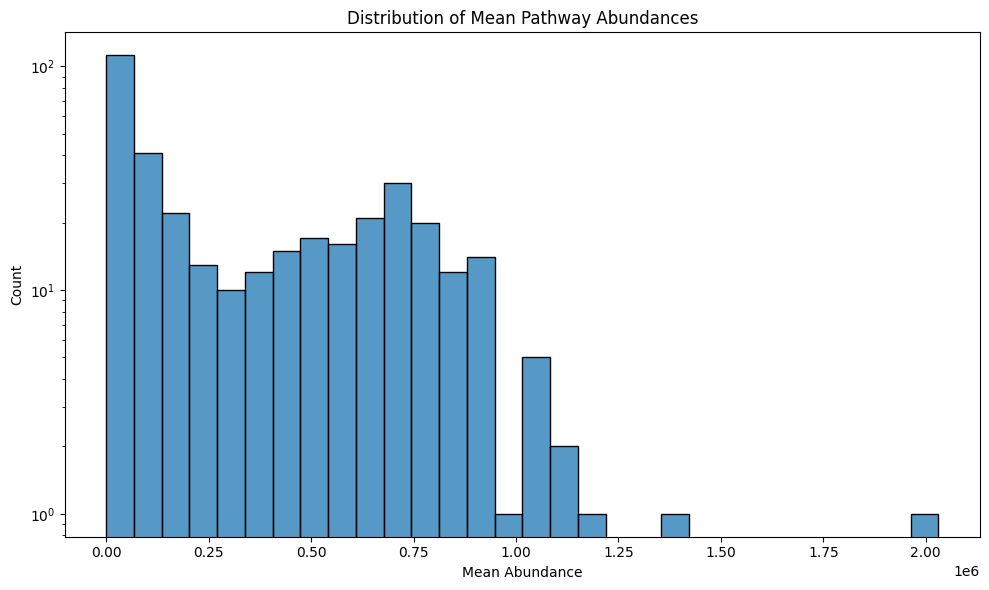

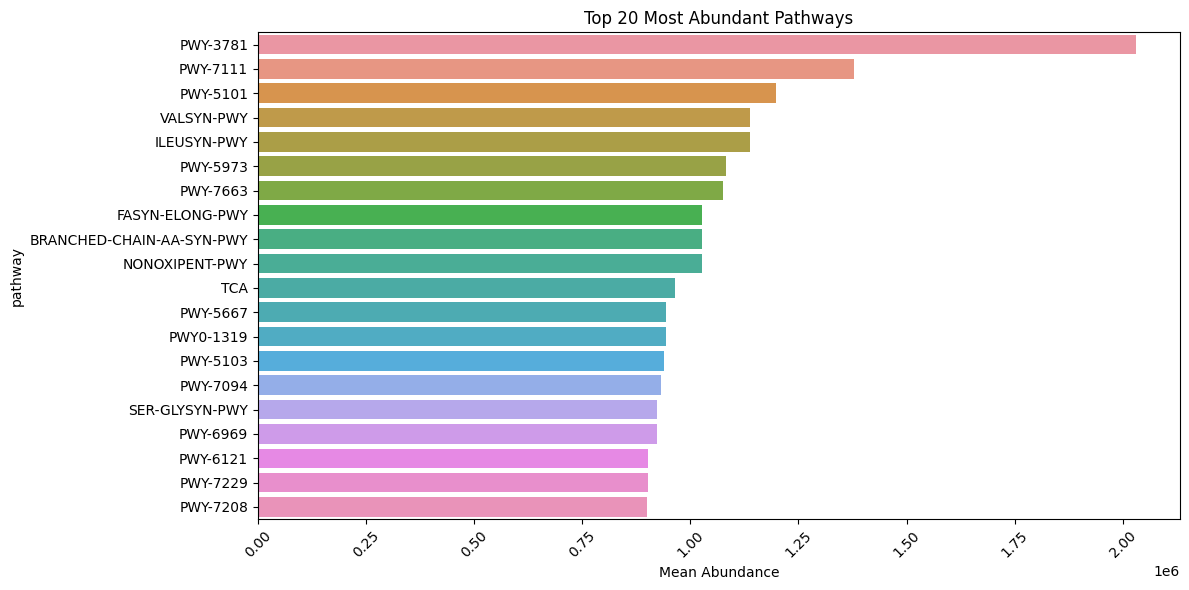


Creating PCA visualization...


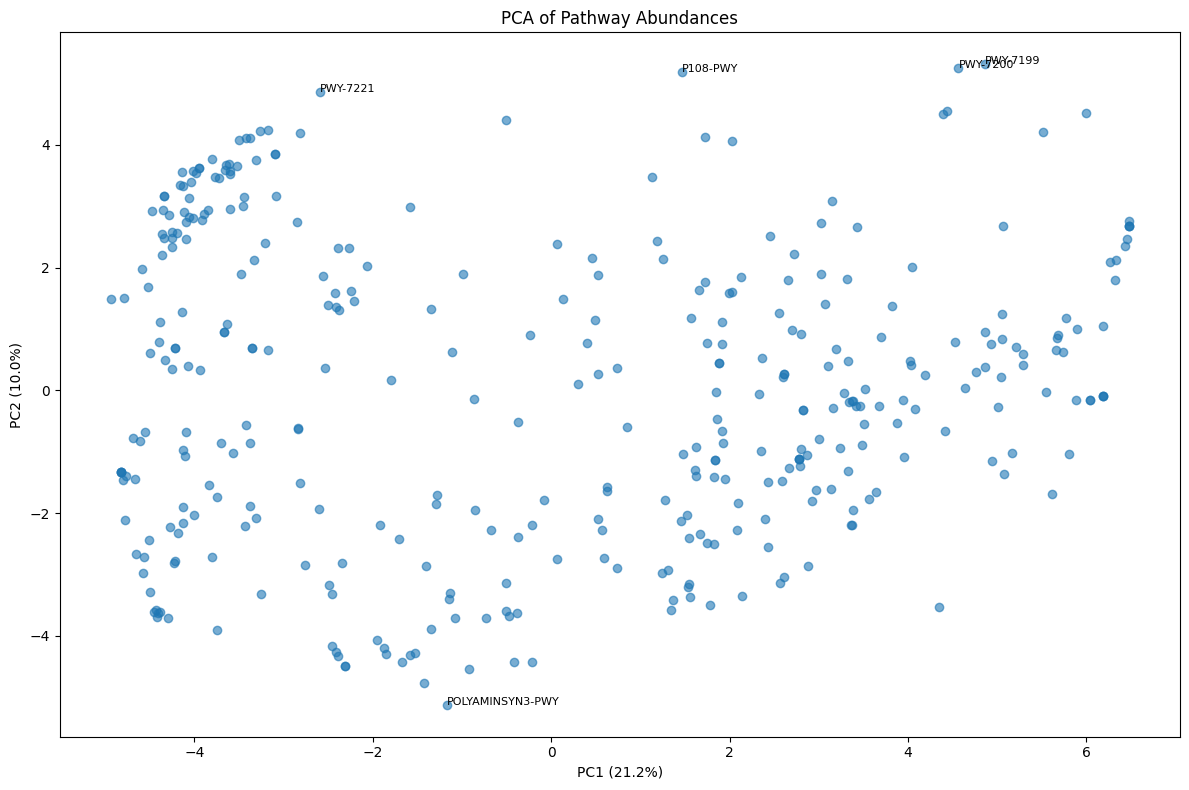


Creating correlation heatmap...


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1200x1200 with 0 Axes>

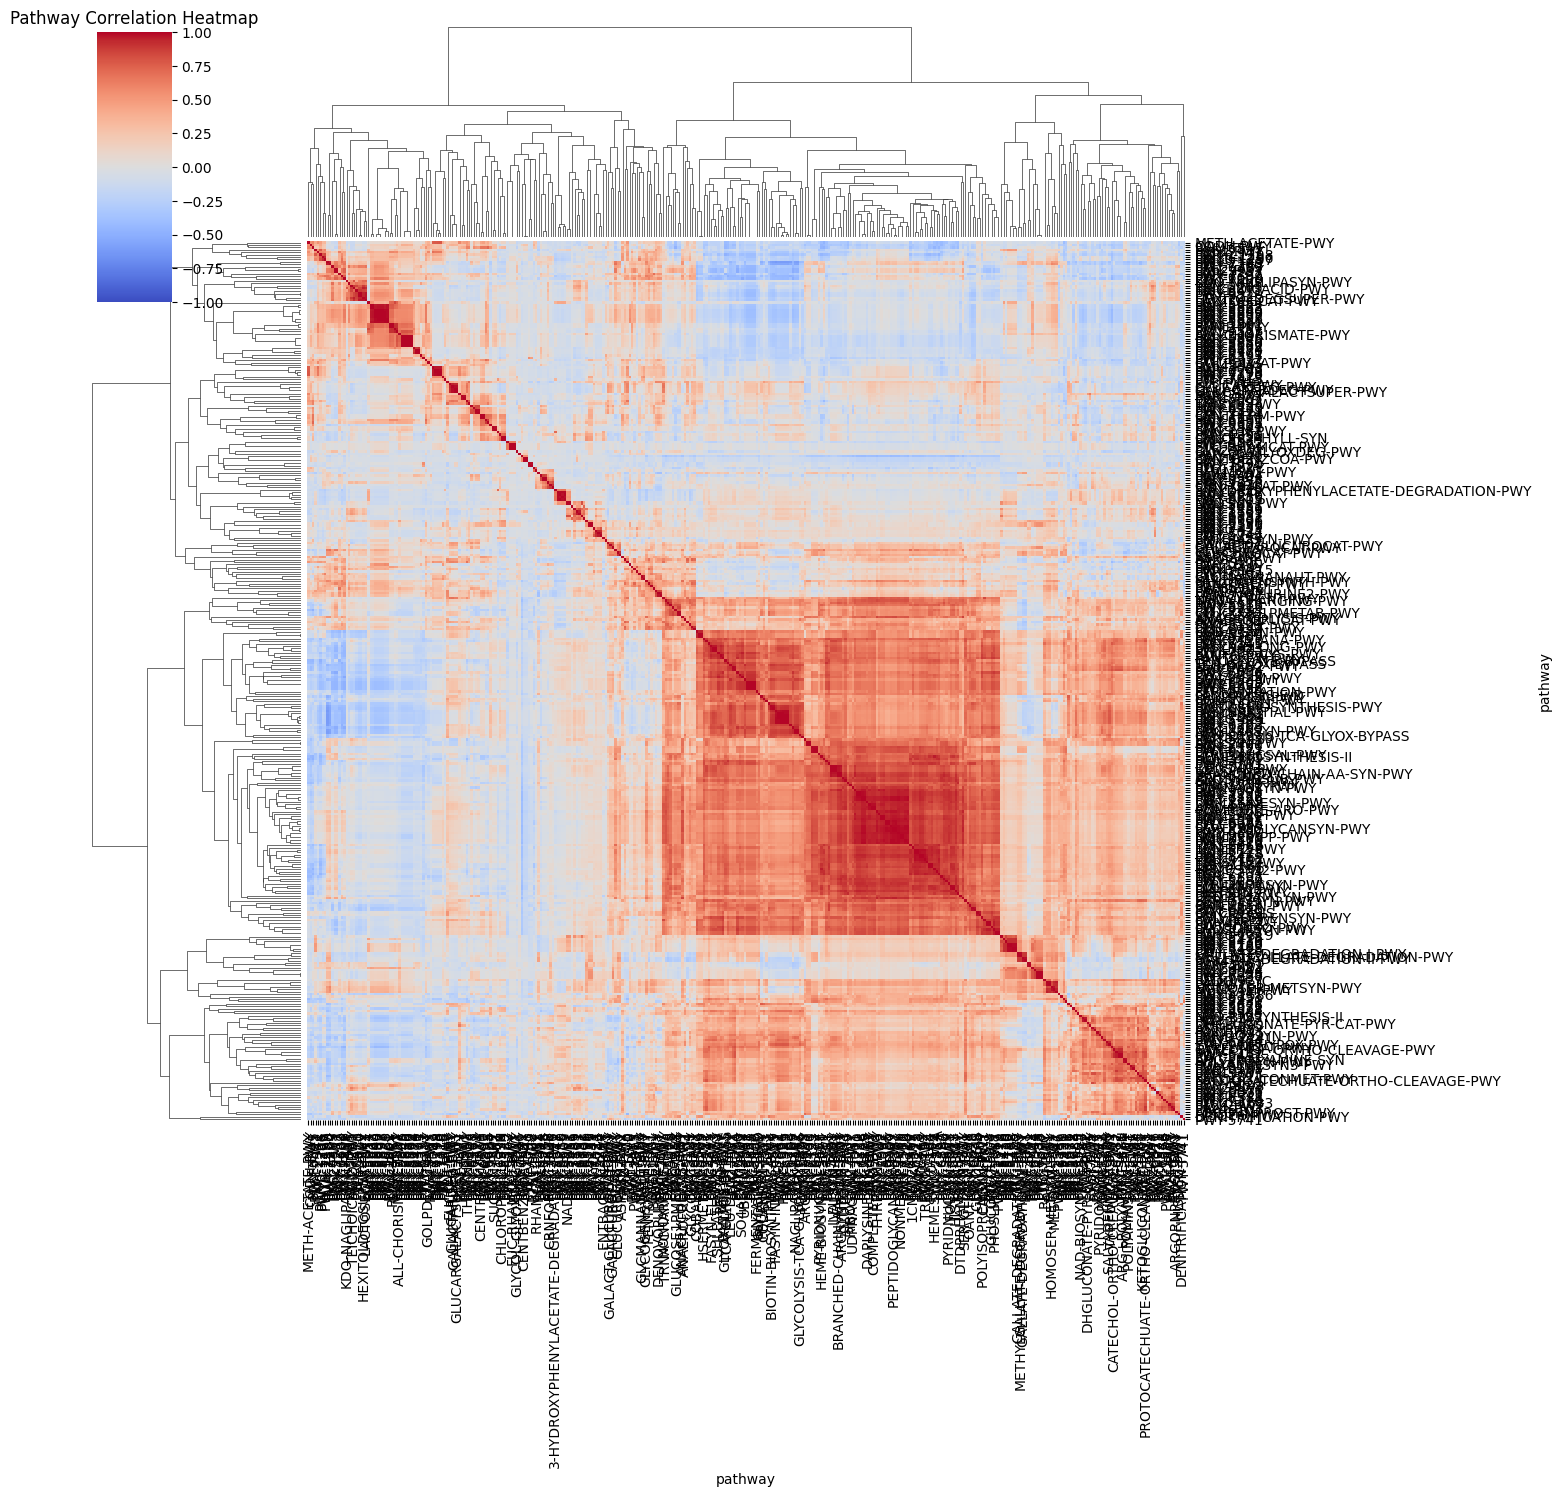


Creating UMAP visualization...


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


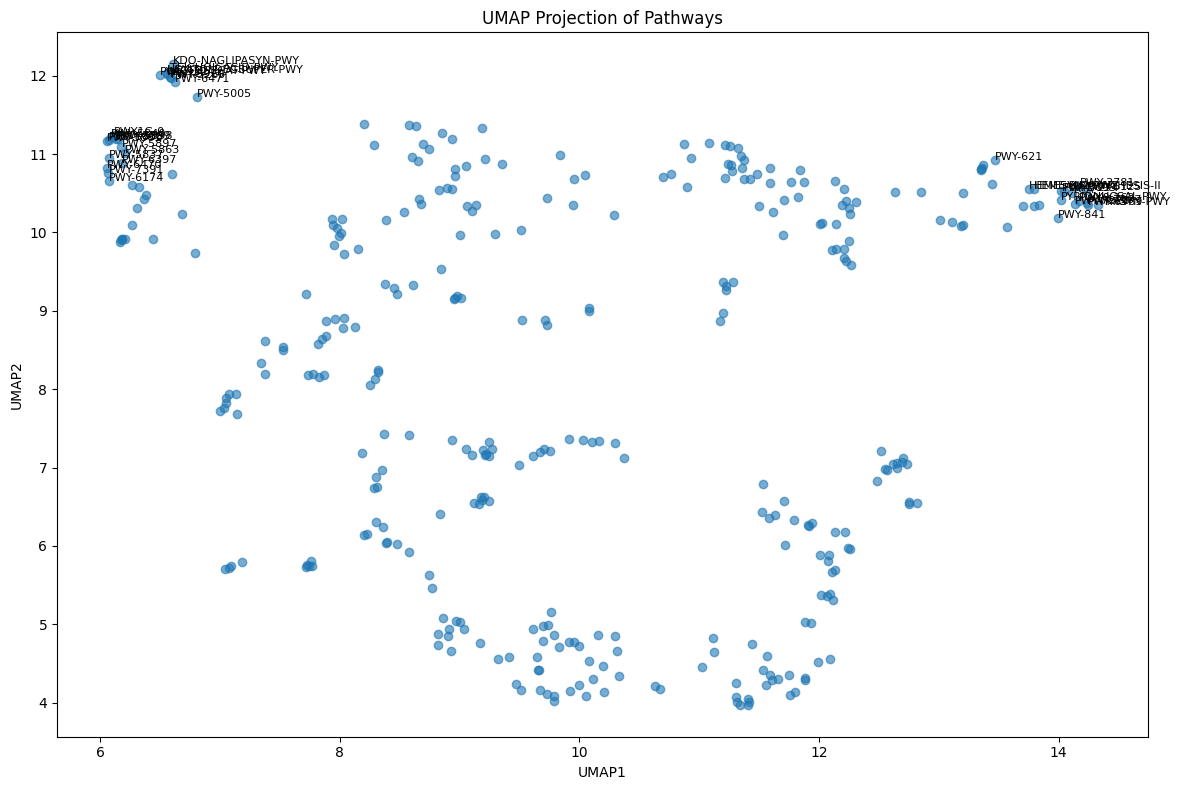

In [21]:
# Calling the function
visualize_pathway_data(Picrust_Result)

## 7.2 Analysing Pathways

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

def analyze_organic_metal_pathways(df):
    """
    Analyze pathways related to organic acid metabolism and metal interactions
    
    Parameters:
    df: pandas DataFrame with pathways as index and samples as columns
    """
    # Define specific pathway categories
    pathway_categories = {
        'organic_acid_metabolism': [
            'acetate', 'acetic acid', 'acetyl',
            'oxalate', 'oxalic acid',
            'organic acid', 'fatty acid',
            'carboxylic acid'
        ],
        
        'metal_organic_interaction': [
            'siderophore', 'metal binding',
            'iron complex', 'metal transport',
            'metallophore', 'metal organic'
        ],
        
        'biofilm_formation': [
            'biofilm', 'exopolysaccharide',
            'extracellular matrix', 'adhesion'
        ],
        
        'halogen_related': [
            'halogen', 'chloride', 'bromide',
            'halide', 'dehalogenation'
        ]
    }
    
    # Analyze each category
    def get_category_pathways(terms):
        return df.index[df.index.str.lower().str.contains('|'.join(terms), regex=True)]
    
    pathway_data = {}
    pathway_stats = {}
    
    for category, terms in pathway_categories.items():
        pathways = get_category_pathways(terms)
        if len(pathways) > 0:
            pathway_data[category] = df.loc[pathways]
            
            # Calculate comprehensive statistics
            pathway_stats[category] = pd.DataFrame({
                'mean_abundance': pathway_data[category].mean(axis=1),
                'std_abundance': pathway_data[category].std(axis=1),
                'cv': pathway_data[category].std(axis=1) / pathway_data[category].mean(axis=1) * 100,
                'presence': (pathway_data[category] > 0).mean(axis=1) * 100,  # % of samples with pathway
                'relative_abundance': pathway_data[category].mean(axis=1) / df.mean(axis=1).mean() * 100
            }).sort_values('mean_abundance', ascending=False)
    
    return pathway_data, pathway_stats

def analyze_pathway_relationships(pathway_data):
    """
    Analyze relationships between different pathway categories
    """
    # Calculate mean abundance for each category across samples
    category_means = pd.DataFrame({
        category: data.mean(axis=0) 
        for category, data in pathway_data.items()
    })
    
    # Calculate correlations
    correlations = category_means.corr()
    
    # Identify potential functional relationships
    high_correlations = correlations.unstack()
    high_correlations = high_correlations[high_correlations != 1.0]
    high_correlations = high_correlations[abs(high_correlations) > 0.5]
    
    return category_means, correlations, high_correlations.sort_values(ascending=False)

def plot_pathway_analysis(pathway_stats, pathway_data):
    """
    Create visualizations for pathway analysis
    """
    for category, stats in pathway_stats.items():
        if len(stats) > 0:
            # Create subplot with dual axis
            fig, ax1 = plt.subplots(figsize=(12, min(8, max(4, len(stats)*0.3))))
            ax2 = ax1.twinx()
            
            # Plot abundance and relative abundance
            sns.barplot(data=stats.head(10).reset_index(), 
                       x='relative_abundance', 
                       y='index',
                       color='skyblue',
                       ax=ax1)
            
            stats.head(10)['presence'].plot(
                marker='o', 
                color='red',
                ax=ax2
            )
            
            ax1.set_title(f'{category.replace("_", " ").title()} Pathways')
            ax1.set_xlabel('Relative Abundance (%)')
            ax2.set_xlabel('Presence (%)')
            
            plt.tight_layout()
            plt.show()

In [25]:
# Calling the function
pathway_data, pathway_stats = analyze_organic_metal_pathways(Picrust_Result)
category_means, correlations, high_corr = analyze_pathway_relationships(pathway_data)
plot_pathway_analysis(pathway_stats, pathway_data)

AttributeError: Can only use .str accessor with string values!

# Burrito

A web tool for interactive visualization of the links between taxonomic composition and function in microbiome datasets
Microbiome sequencing studies typically focus on two related but separate questions: 1) which microbial taxa are present, and 2) what genetic functions are present?

BURRITO is a visualization tool developed to facilitate exploration of both taxonomy and function in microbiome datasets. BURRITO can estimate function abundances from 16S rRNA OTU data, and displays species abundances, function abundances, and the share of each function that can be attributed to each species while simultaneously allowing interactive comparisons between different samples.

BURRITO is located at http://elbo-spice.cs.tau.ac.il/shiny/burrito/

## David

DAVID provides a comprehensive set of functional annotation tools to help understand the biological meaning behind large gene lists. Powered by the DAVID Knowledgebase, it integrates multiple sources of functional annotations. DAVID tools can:

 Identify enriched biological themes, particularly GO terms.
 Discover enriched functional-related gene groups.
 Cluster redundant annotation terms.
 Visualize genes on BioCarta & KEGG pathway maps.
 Display many-genes-to-many-terms relationships in 2D.
 Search for functionally related genes not in the list.
 List interacting proteins.
 Explore gene names in batch mode.

 https://davidbioinformatics.nih.gov/